# Keeping the Event Boundaries

Events contains lists of jets, and perhaps the jets point to lists of tracks - this would be a a triply nested array! `func_adl` is explicit about which level or array you are operating in. It does this by nesting its `Select`, `Where`, and other predicates. `awkward` handles this with the `axis` parameter.

In the previous demo we just ignored this, and looked at the dataset as a giant stream of jets. How does this change if we want to look at jets in each event?

In [1]:
from func_adl_servicex import ServiceXSourceUpROOT
import mplhep as hep
import awkward as ak
from hist import Hist
import matplotlib.pyplot as plt

hep.style.use(hep.style.ATLAS)

## Build our EDM

We will do this in an identical way as to before.

In [2]:
file ="https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root"

ds = ServiceXSourceUpROOT([file], treename="events")

In [3]:
edm = (ds
    .Select(lambda e: {
        'pT': e.jet_pt,
        'eta': e.jet_eta,
        'px': e.jet_px,
        'py': e.jet_py,
        'pz': e.jet_pz,
    }.Zip())
)

## Filtering

This is where we used the `SelectMany` before. Here is the code from last time:

```python
filtered = (edm
    .SelectMany(lambda jets: jets)
    .Where(lambda j: j.pT > 30 and abs(j.eta) < 2.5)
)
```

Instead, we will nest our `Where` statement - it is still operating on a jet as before. But instead of filtering a stream of jets, we are now filtering the stream of jets for each event, one event at a time. We are going to take our list of jets and ask they only be central jets. Note that an empty list is just fine - an event may have no central jets in it!

In [4]:
filtered = (edm
    .Select(lambda jets: jets.Where(lambda j: j.pT > 30 and abs(j.eta) < 2.5))
)

Behind your back, the `uproot` transformer in ServiceX translates this into a column operation!

## Fetching the filtered data

And now we can extract the momentum components, and label them for when they come back as `awkward` arrays. This is very similar to before - except, again, for the nesting. Previously we were operating on single jets, but now we are operating on collections of jets (one per event).

In [5]:
components = (filtered
    .Select(lambda jets: jets.Select(lambda j: {
        'px': j.px,
        'py': j.py,
        'pz': j.pz
    }))
    .AsAwkwardArray()
    .value()
)

[https://xrootd-loca...:   0%|          | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|          | 0/9000000000.0 [00:00]

Previously, the type information looked like this:

```text
components = 181014 * {"px": float32, "py": float32, "pz": float32}
components.ps = 181014 * float32
```

In [6]:
print(f'components = {ak.type(components)}')
print(f'components.ps = {ak.type(components.px)}')

components = 41812 * {"px": var * float32, "py": var * float32, "pz": var * float32}
components.ps = 41812 * var * float32


## Plotting the filtered data

We can use almost the same code to plot the data. Only now we'll have to flatten our arrays before we plot them.

In [7]:
import vector
vector.register_awkward()

as_vector = ak.Array(components, with_name='Momentum3D')

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


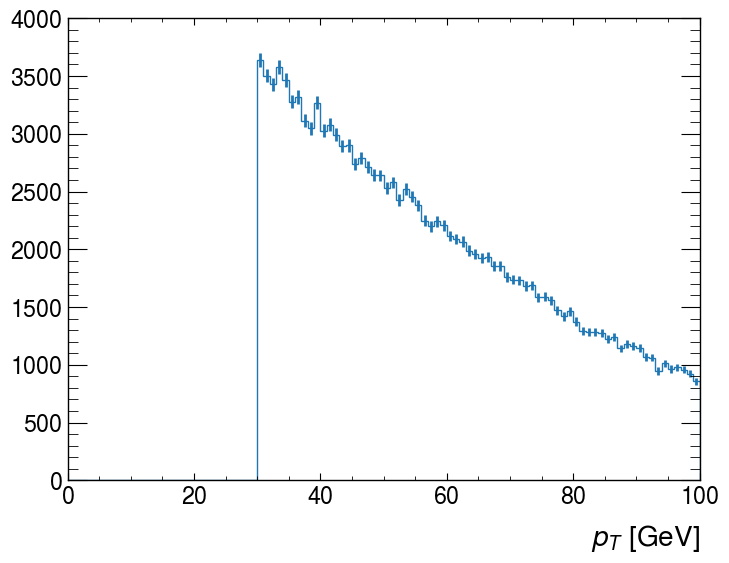

In [8]:
h = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_T$ [GeV]")
  .Int64()
)
h.fill(ak.flatten(as_vector.pt))
h.plot()
plt.show()

Since we've retained the number of jets for each event, we can now do things like plot (or cut) on the number of jets:

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


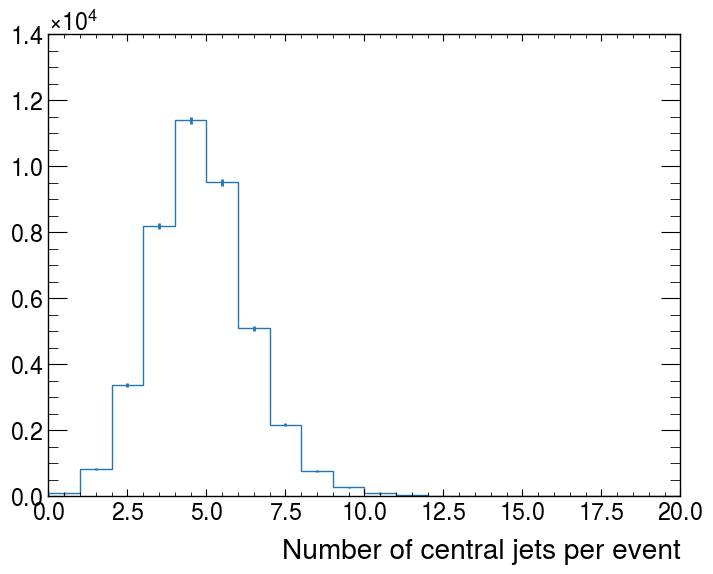

In [9]:
h = (
  Hist.new
  .Reg(20, 0 , 20, name="njets", label="Number of central jets per event")
  .Int64()
)
h.fill(ak.count(as_vector.px, axis=1))
h.plot()
plt.show()